In [1]:
import csv 
import math
import re 

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import nltk
from nltk.downloader import Downloader
from nltk.probability import FreqDist
from nltk.probability import FreqDist
from nltk.corpus import stopwords as stopwords_corpus
from nltk import pos_tag 
from nltk.util import ngrams
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures

In [45]:
downloader = Downloader()
downloader.download("stopwords")
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nicolewhite/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nicolewhite/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [46]:
with open("../data/descriptions.csv", "r") as csvfile:
    reader = csv.reader(csvfile, quoting=csv.QUOTE_ALL)
    documents = [t[0] for t in reader]

matplotlib.rcParams.update({'font.size': 22})
stop_words = set(stopwords_corpus.words("english"))

In [47]:
_non_alpha = re.compile("[^a-zA-Z ]")
def normalize(text):
    """Map a token to a canonical form, e.g. lower case it, remove non-alpha characters, etc. 
    
    Args:
        text (str)
        
    Returns:
        str
    """

    return _non_alpha.sub("", text.lower()).strip()

def filter_text(text):
    """Should we keep this token?
    
    Args:
        text (str)
        
    Returns:
        bool
    """
    return (text and text not in stop_words)
    
def tokenize(text):
    """Turn a string into a stream of tokens.
    
    Args:
        text (str)
        
    Returns:
        list: A list of tokens.
    """
    return text.split(" ")

def analyze(text):
    """Tokenize, Normalize, and Filter the text. 
    
    Args:
        text (str)
        
    Returns:
        generator: A stream of tokens (strings)
    """

    for token in tokenize(text):
        normalized = normalize(token)
        if filter_text(normalized):
            yield normalized

def idf(word, stats):
    """Compute the inverse document frequency of the given word.
    
    Args:
        word (str)
        stats (FreqDist): The corpus statistics.
        
    Returns:
        float
    """
    return math.log(stats.N() / stats[word]) if word in stats else 0

def get_idf_dict(words, stats):
    """
    Args:
        words (list)
        stats (FreqDist): The corpus statistics
        
    Returns:
        dict: A dictionary from word to idf.
    """
    result = {}
    for w in words:
        result[w] = idf(w, stats)
        
    return result

def top_words_by_idf(document, stats, n):
    """Pick the top N words based on IDF values.
    
    Args:
        document (str)
        stats (FreqDist): The corpus statistics
        n: The number of words to keep
        
    Returns:
        list: a list of words
    """
    words = list(analyze(document))
    idfs = get_idf_dict(words, stats)
    words.sort(key=lambda w: -idfs[w])
    return words[0:n]

def top_words_by_tf_idf(document, counts, n):
    """Pick the top N words based on TFIDF values.
    
    Args:
        document (str)
        stats (FreqDist): The corpus statistics
        n: The number of words to keep
        
    Returns:
        list: a list of words
    """
    words = list(analyze(document))
    idfs = get_idf_dict(words, counts)
    tfs = FreqDist(words)
    words.sort(key=lambda w: -(tfs[w] * idfs[w]))
    return words[0:n]

def get_noun_unigrams(doc, to_keep=set(["NN", "NNP"])):
    """Extract all the noun unigrams from a document. 
    
    Args:
        doc (str)
        to_keep (set): The set of POS tags to keep.
    Returns:
        list: a list of words
    """
    tokens = [t for t in tokenize(doc) if t]
    tagged = pos_tag(tokens)
    words = [normalize(word) for word, annotation in tagged if annotation in to_keep]
    return [w for w in words if filter_text(w)]

def get_grammar_chunks(doc, grammar="NP: {<N.*>+}"):
    """Extract a list of chunks that match the specified grammar. 
    
    Args:
        doc(str)
        grammar (str): An NLTK RegexpParser grammar
        
    Returns:
        list: a list of lists of strings, like [['view'], ['Harrison', 'Avenue'], ['Leadville,', 'Colorado.']]
    """
    tokens = [t for t in tokenize(doc) if t]
    tagged = pos_tag(tokens)
    parser = nltk.RegexpParser(grammar)
    parsed = parser.parse(tagged)
    return [[token for token, annotation in subtree.leaves()] 
            for subtree in parsed if hasattr(subtree, "label")]

def bar_chart(freq_dist, columns=["n-gram", "count"], n=20, figsize=(20, 12)):
    """Plot the given FreqDist. 
    
    Args:
        freq_dist (FreqDist): FreqDist or list of tuples.
        columns (list)
        n (int): Number of n-grams to plot
    """
    items = [x for x in freq_dist.items()] if hasattr(freq_dist, "items") else freq_dist
    x, y = columns
    df = pd.DataFrame(items, columns=columns)
    df = df.sort_values(y, ascending=False)[0:n]
    df = df.sort_values(y, ascending=True) # Horizontal Bar Charts are ordered bottom to top. It's nuts.
    df.plot(x=x, y=y, kind="barh", figsize=figsize)

def table(freq_dist, columns=["n-gram", "count"], n=20):
    """Return a dataframe for the given freq_dist
    
    Args:
        freq_dist (FreqDist): FreqDist or list of tuples.
        columns (list)
        n (int): Number of n-grams to plot
    """
    items = [x for x in freq_dist.items()] if hasattr(freq_dist, "items") else freq_dist
    x, y = columns
    df = pd.DataFrame(items, columns=columns)
    return df.sort_values(y, ascending=False)[0:n]

def bigrams(unigram_stats, bigram_stats, measure="pmi", freq_filter=20):
    """Produce a list of scored bigrams. 
    
    Args:
        unigram_stats (FreqDist)
        bigram_stats (FreqDist)
        measure (str): a measure like "pmi" or "student_t". Should be an attribute of BigramAssocMeasures
        freq_filter (int): minimum number of occurences to consider a bigram
    """

    finder = BigramCollocationFinder(unigram_stats, bigram_stats)
    finder.apply_freq_filter(freq_filter)
    measures = BigramAssocMeasures()
    return finder.score_ngrams(getattr(measures, measure))

def freq_dist_to_csv(freq_dist, output_file_name, include_freq=False):
    """Print the given FreqDist to a csv, sorted by term.
    
    Args:
        freq_dist (FreqDist)
        output_file_name (str): a file name
    """
    items = [i for i in freq_dist.items()]
    items.sort(key=lambda x: x[0])
    with open("../output/%s" % output_file_name, "w") as csvfile:
        writer = csv.writer(csvfile, quoting=csv.QUOTE_ALL)
        for item in items:
            if include_freq:
                writer.writerow(item)
            else:
                writer.writerow([item[0]])

In [48]:
stats = FreqDist()

for d in documents:
    for word in d.split(" "):
        word = normalize(word)
        if word:
            stats[word.lower()] += 1

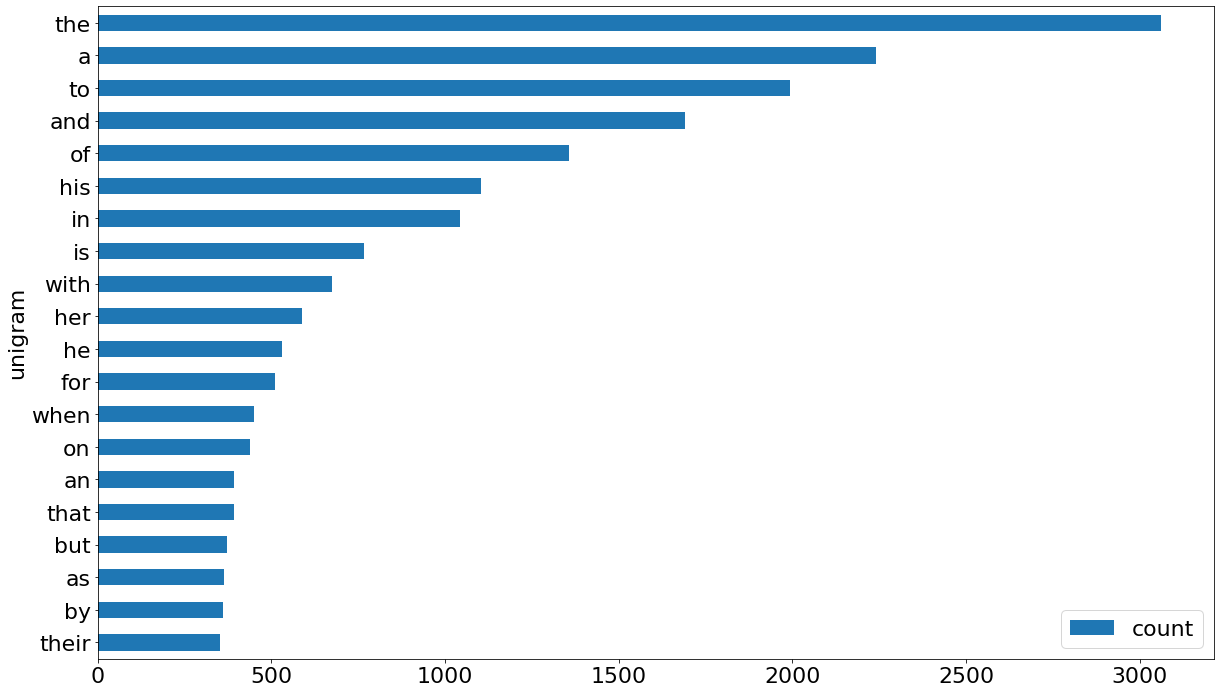

In [49]:
bar_chart(stats, columns=["unigram", "count"])

In [50]:
unigram_freqdist = FreqDist()

for d in documents:
    for word in analyze(d):
        unigram_freqdist[word] += 1

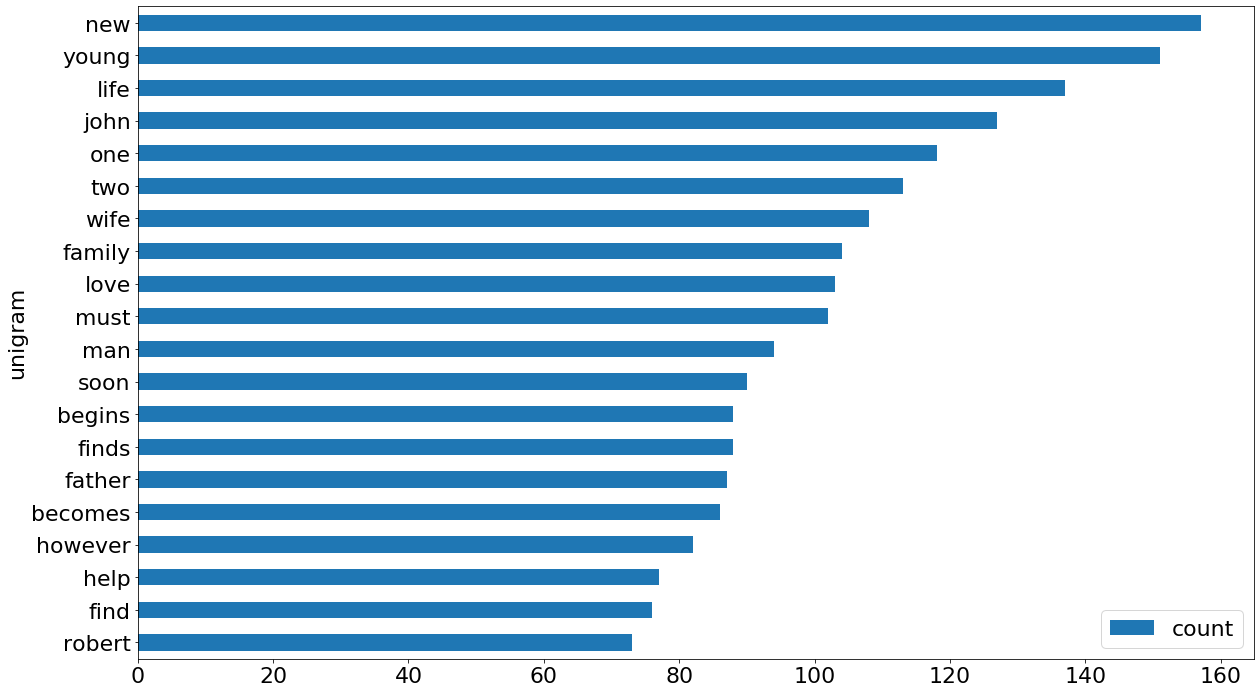

In [51]:
bar_chart(unigram_freqdist, columns=["unigram", "count"])

In [52]:
idf_filtered_freqdist = FreqDist()

for d in documents:
    for w in top_words_by_idf(d, unigram_freqdist, 10):
        idf_filtered_freqdist[w] += 1

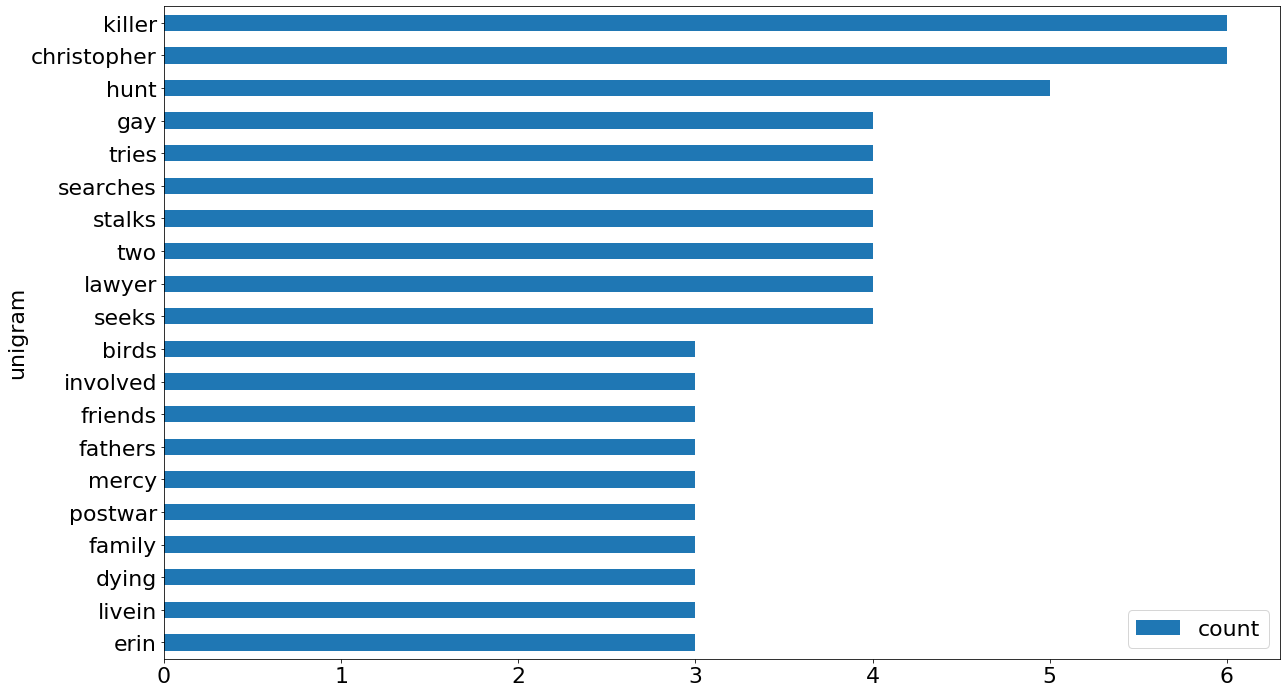

In [53]:
bar_chart(idf_filtered_freqdist, columns=["unigram", "count"])

In [54]:
tf_idf_filtered_freqdist = FreqDist()
        
for d in documents:
    for w in top_words_by_tf_idf(d, unigram_freqdist, 10):
        tf_idf_filtered_freqdist[w] += 1

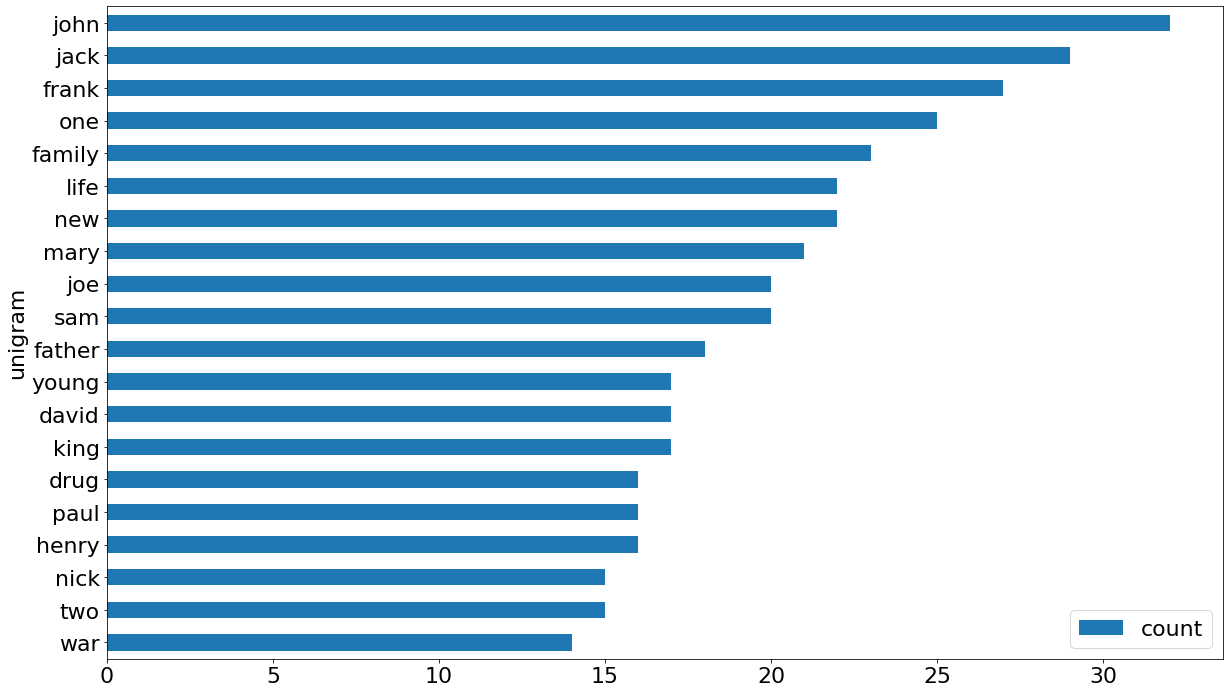

In [55]:
bar_chart(tf_idf_filtered_freqdist, columns=["unigram", "count"])

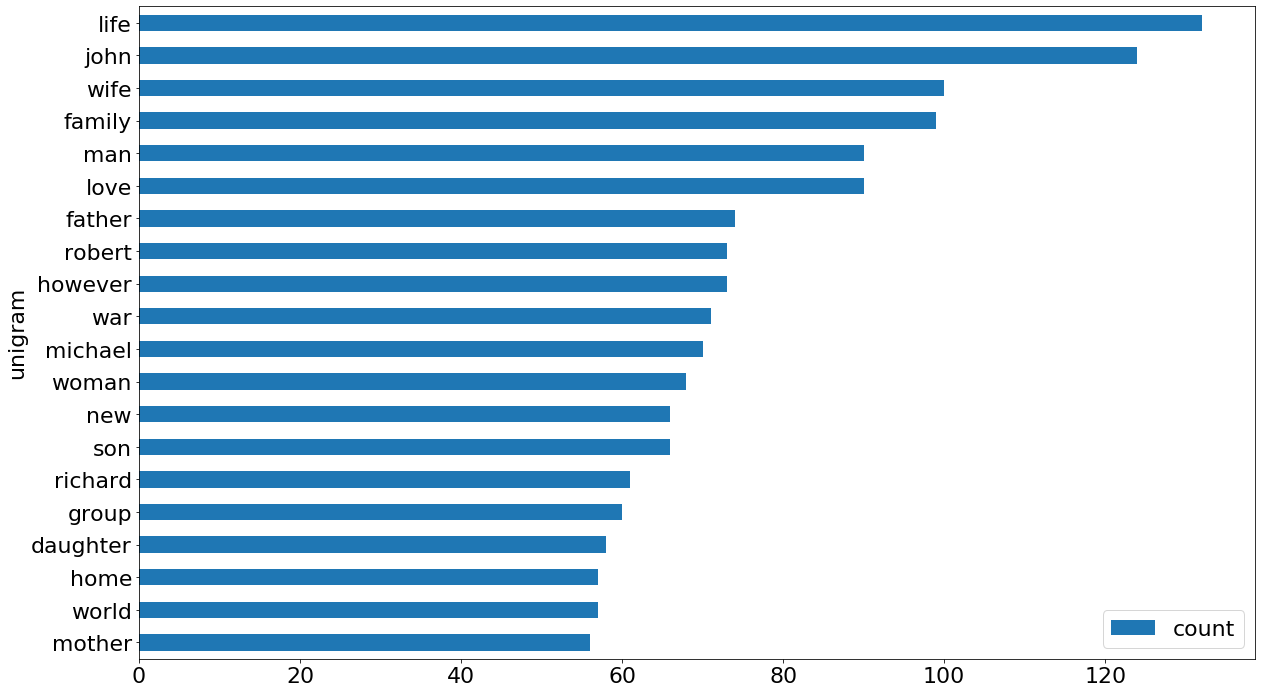

In [56]:
pos_filtered_freqdist = FreqDist()

for d in documents:
    for w in get_noun_unigrams(d):
        pos_filtered_freqdist[w] += 1

bar_chart(pos_filtered_freqdist, columns=["unigram", "count"])

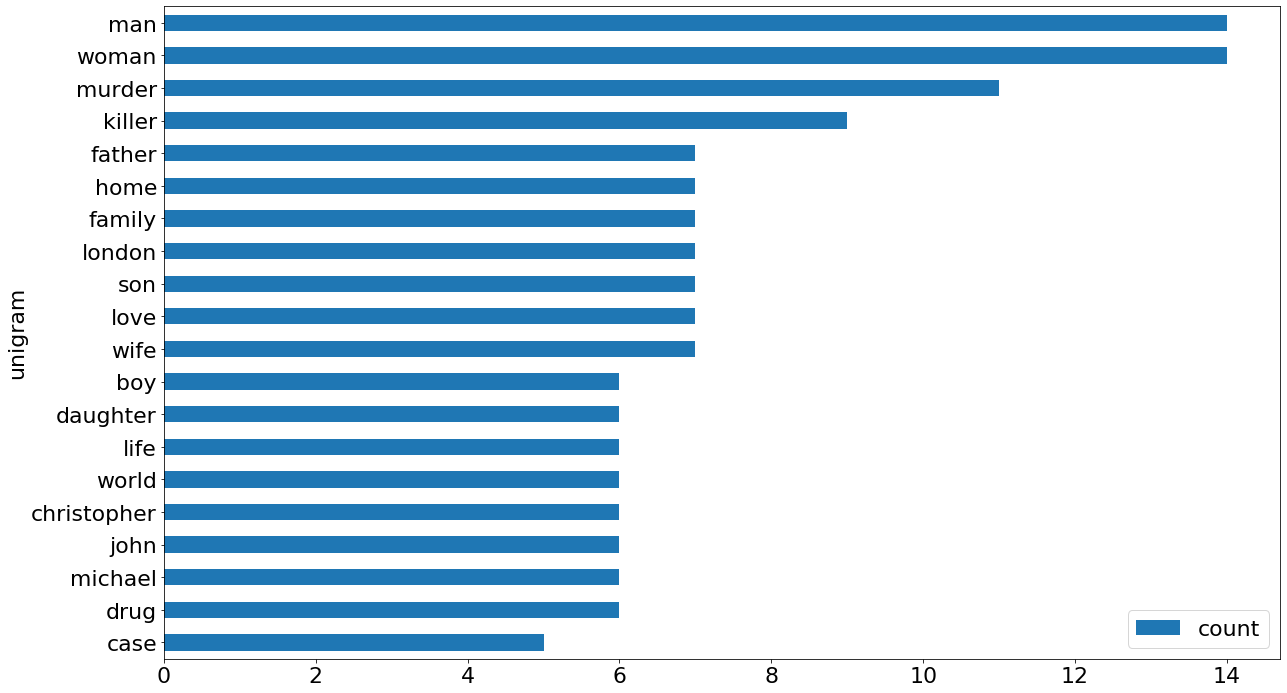

In [57]:
# Let's try POS with TF-IDF:
def top_nouns_by_idf(document, stats, n):
    """Pick the top N nouns based on IDF values.
    
    Args:
        document (str)
        stats (FreqDist): The corpus statistics
        n: The number of words to keep
        
    Returns:
        list: a list of words
    """
    words = list(get_noun_unigrams(document))
    idfs = get_idf_dict(words, stats)
    words.sort(key=lambda w: -idfs[w])
    return words[0:n]

pos_and_idf_filtered_freqdist = FreqDist()

for d in documents:
    for w in top_nouns_by_idf(d, pos_filtered_freqdist, 10):
        pos_and_idf_filtered_freqdist[w] += 1

bar_chart(pos_and_idf_filtered_freqdist, columns=["unigram", "count"])

In [58]:
bigram_freq = FreqDist()
unigram_freq = FreqDist()

for d in documents:
    for token in analyze(d):
        unigram_freq[token] += 1 
        
    for one, two in ngrams(tokenize(d), 2):
        normalized = (normalize(one), normalize(two))
        n0, n1 = normalized
        if filter_text(n0) and filter_text(n1):
            bigram_freq[normalized] += 1

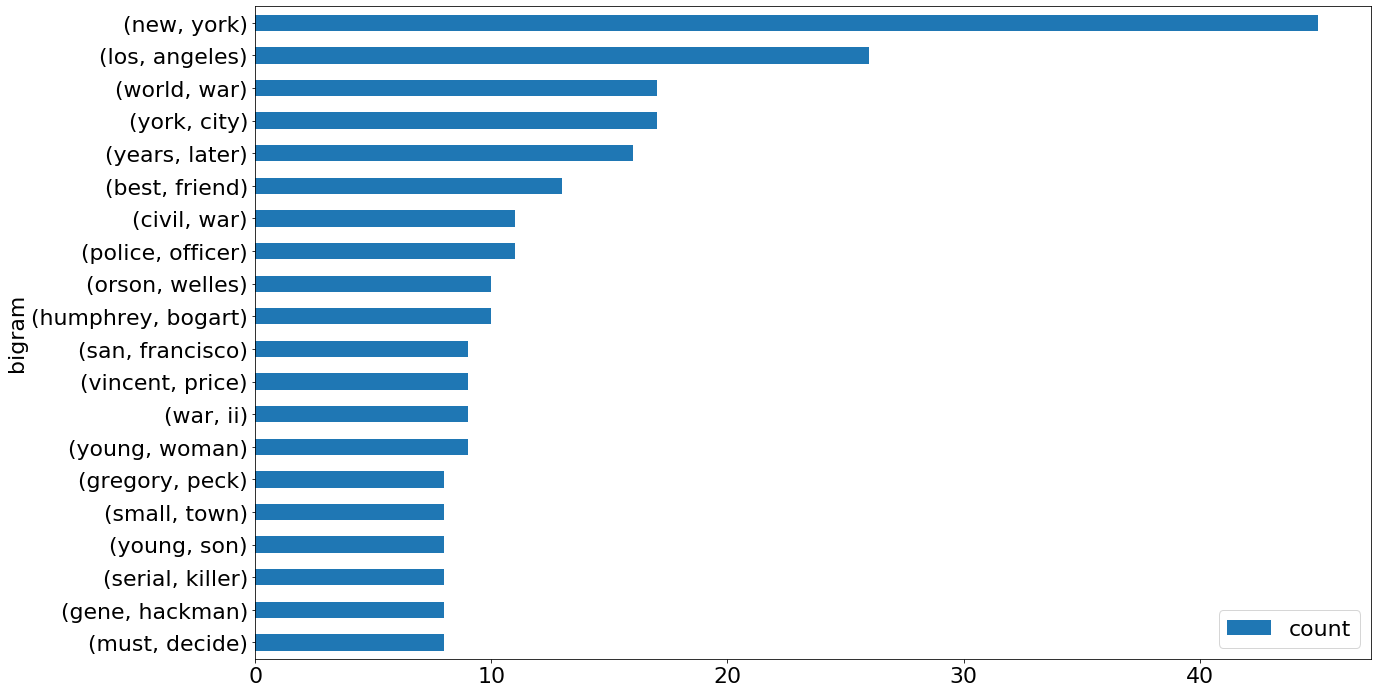

In [59]:
bar_chart(bigram_freq, columns=["bigram", "count"])

In [60]:
pos_bigram_freq = FreqDist()
pos_unigram_freq = FreqDist()

for d in documents:
    for chunk in get_grammar_chunks(d):
        for token in chunk:
            normalized = normalize(token)
            if filter_text(normalized):
                pos_unigram_freq[normalized] += 1
 
        for one, two in ngrams(chunk, 2):
            normalized = (normalize(one), normalize(two))
            n0, n1 = normalized
            if filter_text(n0) and filter_text(n1):
                pos_bigram_freq[normalized] += 1

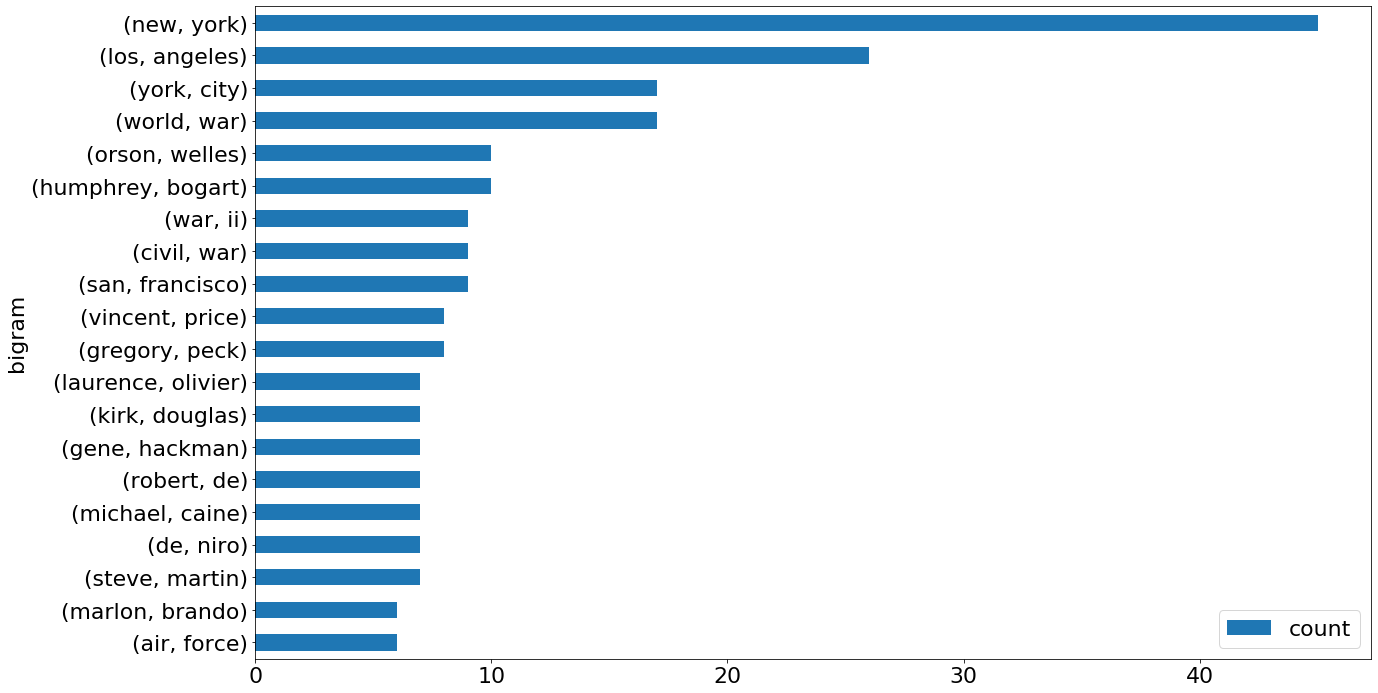

In [61]:
bar_chart(pos_bigram_freq, columns=["bigram", "count"])

In [63]:
# Our baseline is the set of unigrams that appeared at least 5 times.
baseline_unigrams = { term: count for term, count in unigram_freqdist.items() if count > 5}

def get_ground_truth():
    with open("../data/ground_truth.csv", "r") as csvfile:
        reader = csv.reader(csvfile, quoting=csv.QUOTE_ALL)
        return [(t[0], int(t[1])) for t in reader]
    
def predict_from_dataset(dataset, terms):
    return [1 if term in dataset else 0 for term in terms]

def baseline_unigram_predict(terms):
    return predict_from_dataset(baseline_unigrams, terms)

def pos_unigram_predict(terms):
    return predict_from_dataset(pos_filtered_freqdist, terms)

# A list of (term, yes/no), like [("foo", 1)]
ground_truth = get_ground_truth()
terms = [term for term, label in ground_truth]
labels = [label for term, label in ground_truth]

baseline_labels = baseline_unigram_predict(terms)
pos_filtered_labels = pos_unigram_predict(terms)

from sklearn.metrics import f1_score

baseline_score = f1_score(labels, baseline_labels)
pos_filtered_score = f1_score(labels, pos_filtered_labels)
print("Baseline F1: %f" % baseline_score)
print("POS Filtered F1: %f" % pos_filtered_score)

Baseline F1: 0.878049
POS Filtered F1: 0.790698


In [65]:
from nltk import pos_tag
pos_tag(tokenize("Several men stand, and one sits, on the corner boardwalk opposite the hotel."))

[('Several', 'JJ'),
 ('men', 'NNS'),
 ('stand,', 'VBD'),
 ('and', 'CC'),
 ('one', 'CD'),
 ('sits,', 'NN'),
 ('on', 'IN'),
 ('the', 'DT'),
 ('corner', 'NN'),
 ('boardwalk', 'NN'),
 ('opposite', 'IN'),
 ('the', 'DT'),
 ('hotel.', 'NN')]